In [2]:
%load_ext autoreload
%autoreload 2

import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## For mean 

In [3]:
def get_scores(results, all_code=True):
    metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")
    modes = ("only_text", "only_code") if all_code else ("only_text", "only_python")
    # injection_coefficients = list(results["only_code"].keys())

    scores = {}
    for mode in modes:
        scores[mode] = {}
        for metric in metrics:
            scores[mode][metric] = {"avg": [], "rel": []}
            # for ic in injection_coefficients:
            for ic_score in results[mode].values():
                if metric in ("top1_acc", "top10_acc"):
                    scores[mode][metric]["avg"].append(
                        100
                        * np.average(
                            ic_score[metric],
                            weights=ic_score["total_encoded_tokens"],
                        )
                    )
                else:
                    scores[mode][metric]["avg"].append(
                        100
                        * np.average(
                            ic_score[metric],
                            weights=ic_score["total_tokens_with_skip"],
                        )
                    )
            avg_scores = scores[mode][metric]["avg"]
            scores[mode][metric]["rel"] = [i / avg_scores[0] * 100 for i in avg_scores]
    return scores

In [4]:
versions = [
    "4.07",
    "4.08",
    "4.09",
    "4.10",
    "4.11",
    "4.12",
    "4.14",
    "4.15",
    "4.16",
    # "4.09",
]

results = []
for version in versions:
    # with open(f"../results/alignment_tax_v{str(version)}.json", "r") as f:
    with open(f"../results/v_{version}.json", "r") as f:
        results.append(json.load(f))

for version, r in zip(versions, results):
    print(f"Version {version} note: {r['meta']['note']} layer: {r['meta']['layers']}") 

Version 4.07 note: mode only text instead of all layer: [25]
Version 4.08 note: mode only text instead of all layer 30 layer: [30]
Version 4.09 note: mode only text instead of all layer 10 layer: [10]
Version 4.10 note: mode only text instead of all layer 5 layer: [5]
Version 4.11 note: mode only text instead of all layer 15 layer: [15]
Version 4.12 note: mode only text instead of all layer 20 layer: [20]
Version 4.14 note: mode add only_text activations layer 10 layer: [10]
Version 4.15 note: mode add only_text and all activations layer 10 layer: [10]
Version 4.16 note: mode add only all activations layer 10 layer: [10]


In [91]:
scores = [get_scores(res, all_code=False) for res in results] 

labels = [
    "layer 25",
    "layer 30",
    "layer 10",
    "layer 10",
    "layer 10",
    "layer 10",
    "layer 10",
    "layer 10",

    ]

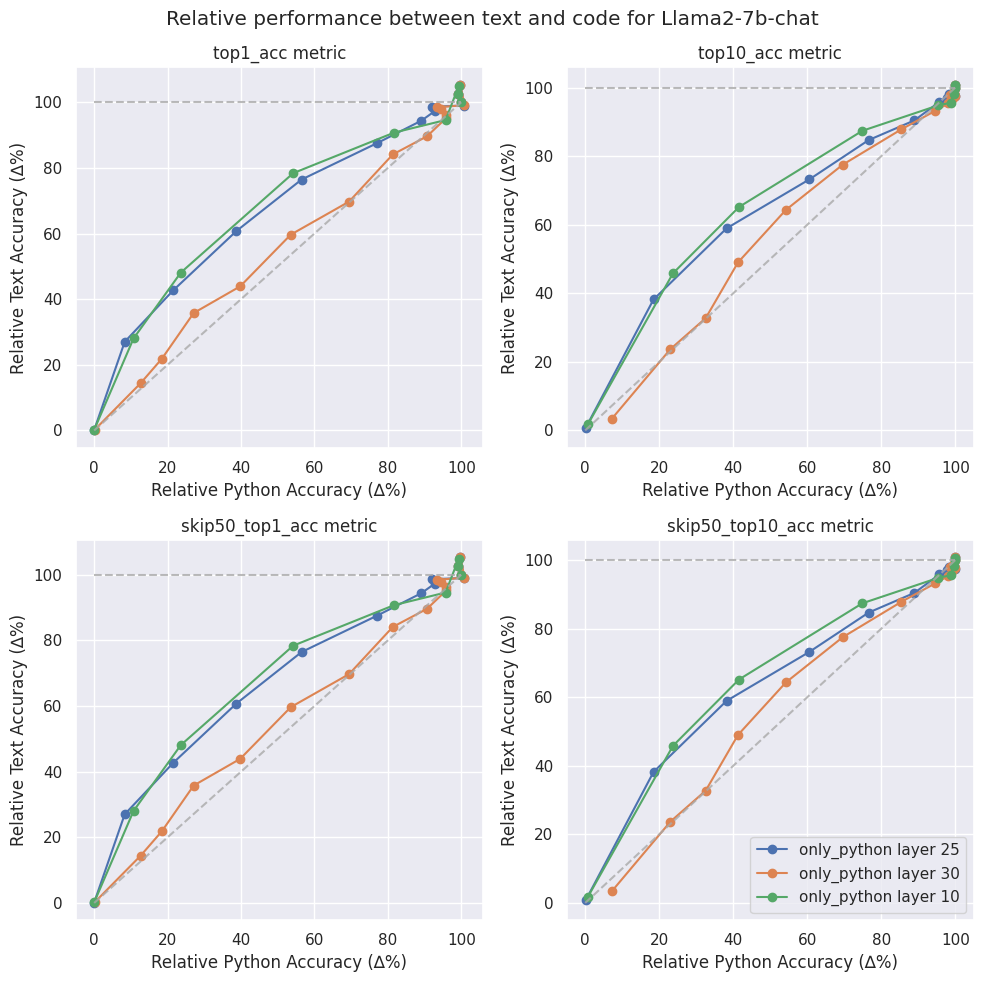

In [92]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scale = 100
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")

for metric, ax in zip(metrics, axs.reshape(-1)):
    for label, score in zip(labels, scores):
        # ax.plot(score["only_code"][metric]["rel"], score['only_text'][metric]["rel"], marker="o", label=label)
        ax.plot(score["only_python"][metric]["rel"], score['only_text'][metric]["rel"], marker="o", label=label)

    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Relative Python Accuracy (∆%)")
    # ax.set_xlabel("Relative Code Accuracy (∆%)")
    ax.set_ylabel("Relative Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0, scale], color="darkgray", linestyle="--", alpha=0.8)

plt.legend()
title = "Relative performance between text and code for Llama2-7b-chat"
# txt = """This Figure illustrates the differences in relative code and text performance for multiple activation manipulations. 
# The performance is measures given the original score (100, 100) generated by the model without any modifications."""
# plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment="center", fontsize=12)

plt.suptitle(title)
fig.tight_layout()
plt.show()

In [67]:
scores[-1]

{'only_python': {'top1_acc': {'avg': [81.96423894845769,
    81.02482927284316,
    80.82718090953658,
    79.66662833604057,
    73.49148873686576,
    73.74736260317529,
    71.27126772561827,
    70.34460428408696,
    63.002984127106664,
    56.45476225044595,
    48.8745198447891,
    39.043970865372394,
    25.205886754107965,
    19.380285246434724,
    15.607412964388404,
    11.625439164831324,
    6.450970777200564,
    3.8367088116780184],
   'rel': [100.0,
    98.8538786089318,
    98.61273885598311,
    97.19681333970301,
    89.66286966085303,
    89.97504710505578,
    86.9541017399508,
    85.82353131872839,
    76.86642972031424,
    68.87730914691578,
    59.62907784152465,
    47.63537289710549,
    30.752297681868807,
    23.64480594838659,
    19.041734742639353,
    14.183550428793529,
    7.8704699268386875,
    4.680954597883463]},
  'top10_acc': {'avg': [95.77656033658062,
    95.30212989211464,
    95.52348066829146,
    94.98740339942402,
    93.8571656036882

KeyError: 'only_python'

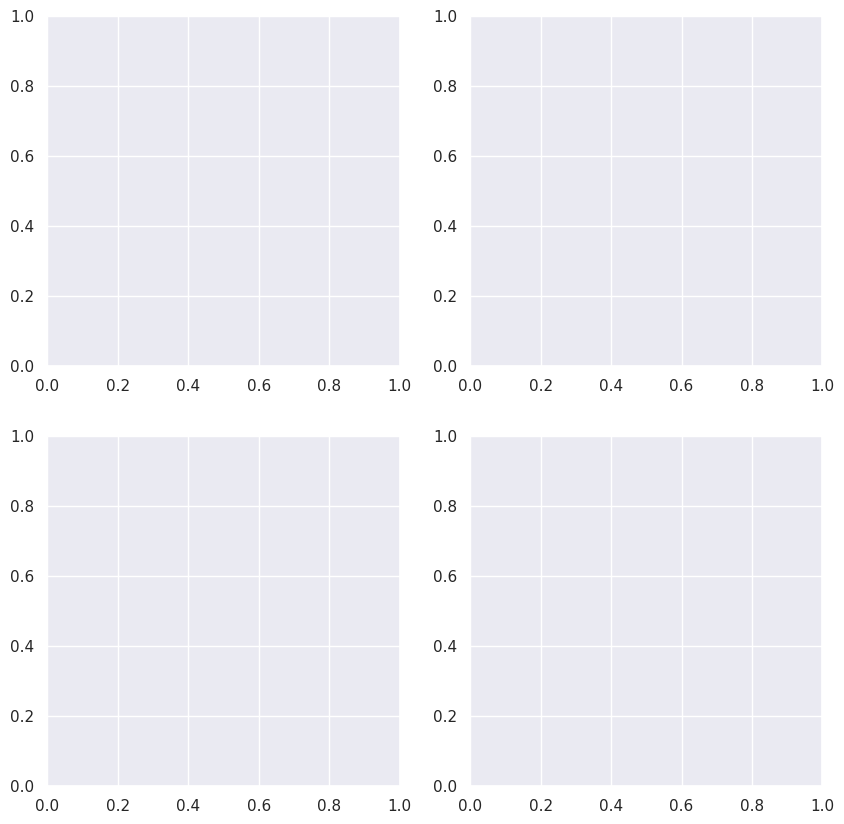

In [11]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scale = 100
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")

for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.plot(scores[-1]["only_python"][metric]["rel"], scores[-1]['only_text'][metric]["rel"], marker="o", label="only python")

    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Relative Code Accuracy (∆%)")
    ax.set_ylabel("Relative Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0, scale], color="darkgray", linestyle="--", alpha=0.8)

plt.legend()
title = "Relative performance between text and code for Llama2-7b-chat"
# txt = """This Figure illustrates the differences in relative code and text performance for multiple activation manipulations. 
# The performance is measures given the original score (100, 100) generated by the model without any modifications."""
# plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment="center", fontsize=12)

plt.suptitle(title)
fig.tight_layout()
plt.show()

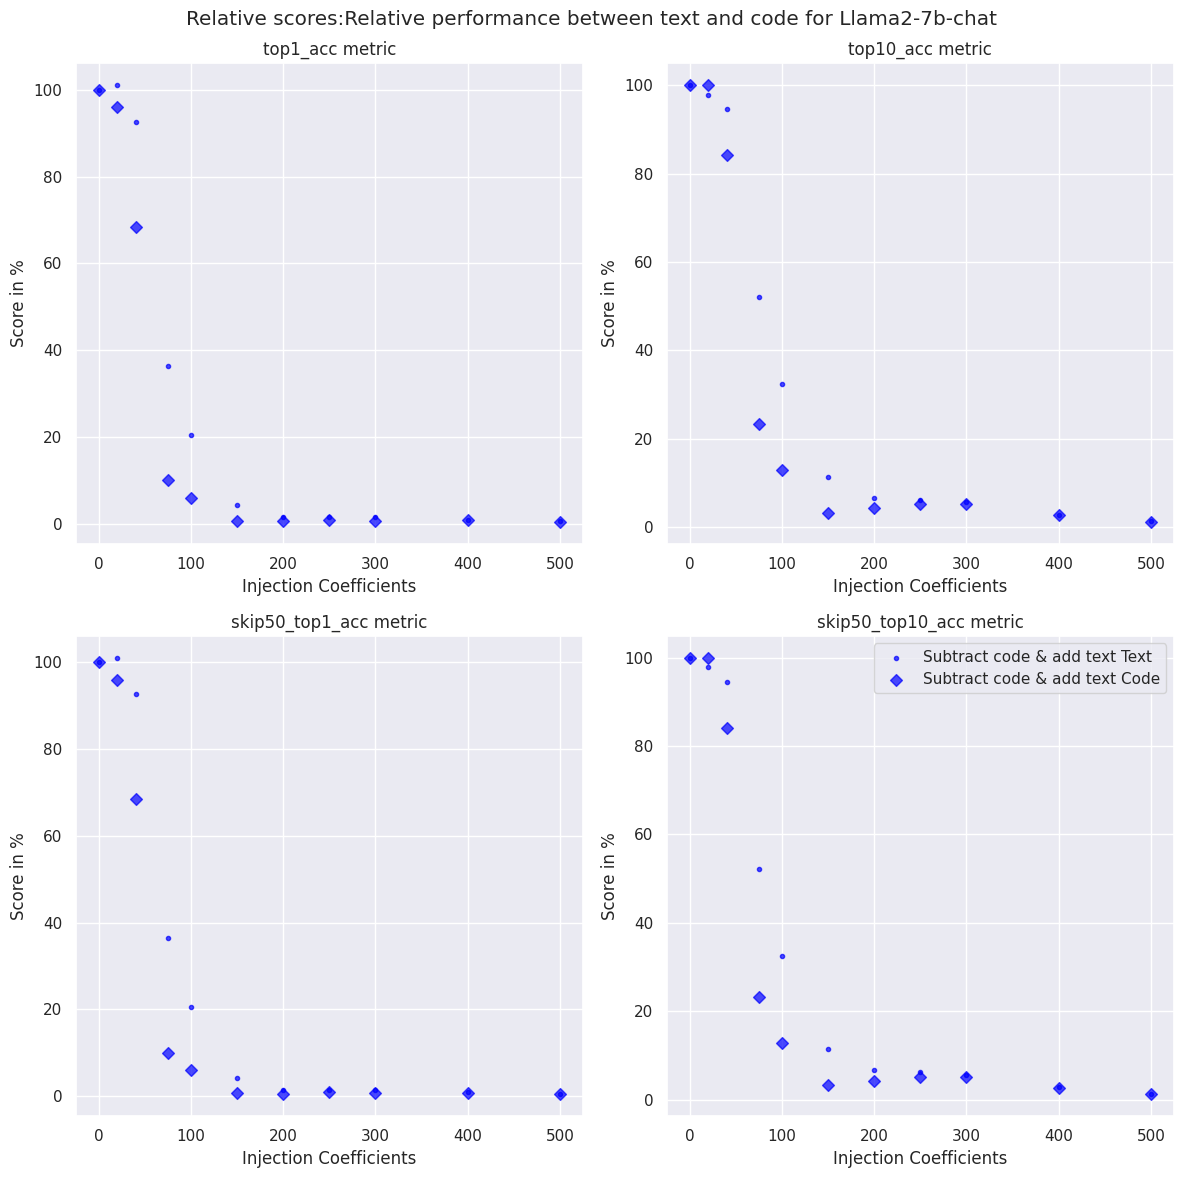

In [9]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))  # , sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    # ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["rel"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["rel"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

plt.legend()
plt.suptitle("Relative scores:" + title)
fig.tight_layout()
plt.show()

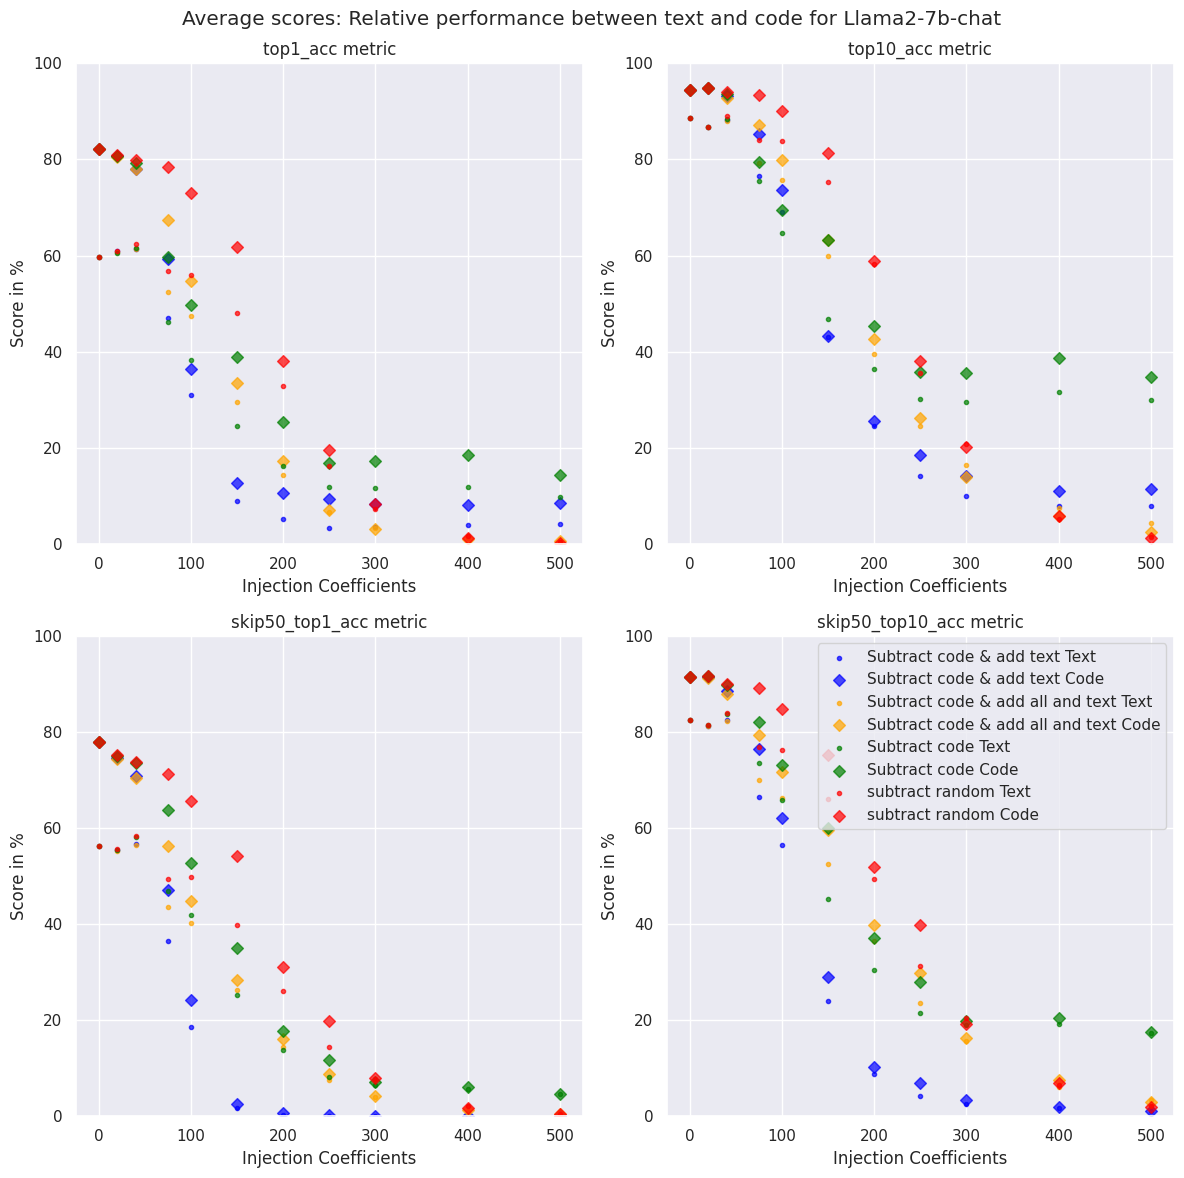

In [12]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))#, sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["avg"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["avg"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

plt.legend()
plt.suptitle("Average scores: " + title)
fig.tight_layout()
plt.show()

## For PCA

In [3]:
#NOTE: omitting random
# versions = [2.08, 2.09, 2.11, 2.12]
versions = [2.13]
results = []
for version in versions:
    with open(f"../results/alignment_tax_v{str(version)}.json", "r") as f:
        results.append(json.load(f))

#NOTE: notes are wrong
[print(r["meta"]["note"]) for r in results]

PCA subtract code and all, add text


[None]

In [4]:
def get_scores(results):
    metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")
    modes = ("only_text", "only_code")
    injection_coefficients = list(results["only_code"].keys())

    scores = {}
    for mode in modes:
        scores[mode] = {}
        for metric in metrics:
            scores[mode][metric] = {"avg": [], "rel": []}
            for ic in injection_coefficients:
                if metric in ("top1_acc", "top10_acc"):
                    scores[mode][metric]["avg"].append(100*np.average(results[mode][ic][metric], weights=results[mode][ic]["total_encoded_tokens"]))
                else:
                    scores[mode][metric]["avg"].append(100*np.average(results[mode][ic][metric], weights=results[mode][ic]["total_tokens_with_skip"]))
            avg_scores = scores[mode][metric]["avg"]
            scores[mode][metric]["rel"] = [i/avg_scores[0]*100 for i in avg_scores]
    return scores

In [9]:
scores = [get_scores(res) for res in results] 

labels = [
    "Subtract code & all, add text",
]

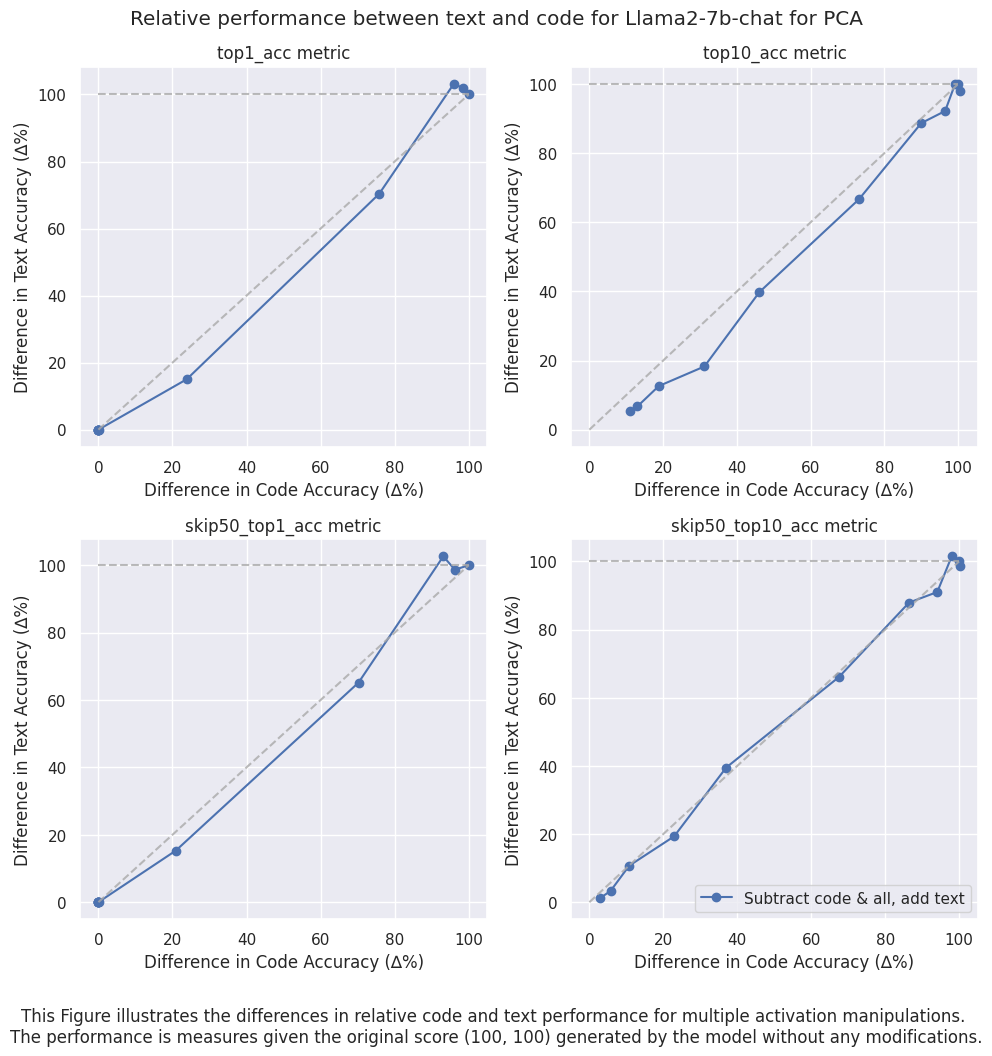

In [10]:
# create a seaborn style graph
sns.set_theme()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
scale = 100
metrics = ("top1_acc", "top10_acc", "skip50_top1_acc", "skip50_top10_acc")

for metric, ax in zip(metrics, axs.reshape(-1)):
    for label, score in zip(labels, scores):
        ax.plot(score["only_code"][metric]["rel"], score['only_text'][metric]["rel"], marker="o", label=label)

    ax.set_title(f"{metric} metric")
    ax.set_xlabel("Difference in Code Accuracy (∆%)")
    ax.set_ylabel("Difference in Text Accuracy (∆%)")

    ax.plot([0, scale], [scale, scale], color="darkgray", linestyle="--", alpha=0.8)
    ax.plot([0, scale], [0,     scale], color="darkgray", linestyle="--", alpha=0.8)

plt.legend()
title = "Relative performance between text and code for Llama2-7b-chat for PCA"
txt = """This Figure illustrates the differences in relative code and text performance for multiple activation manipulations. 
The performance is measures given the original score (100, 100) generated by the model without any modifications."""
plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=12)

plt.suptitle(title)
fig.tight_layout()
plt.show()

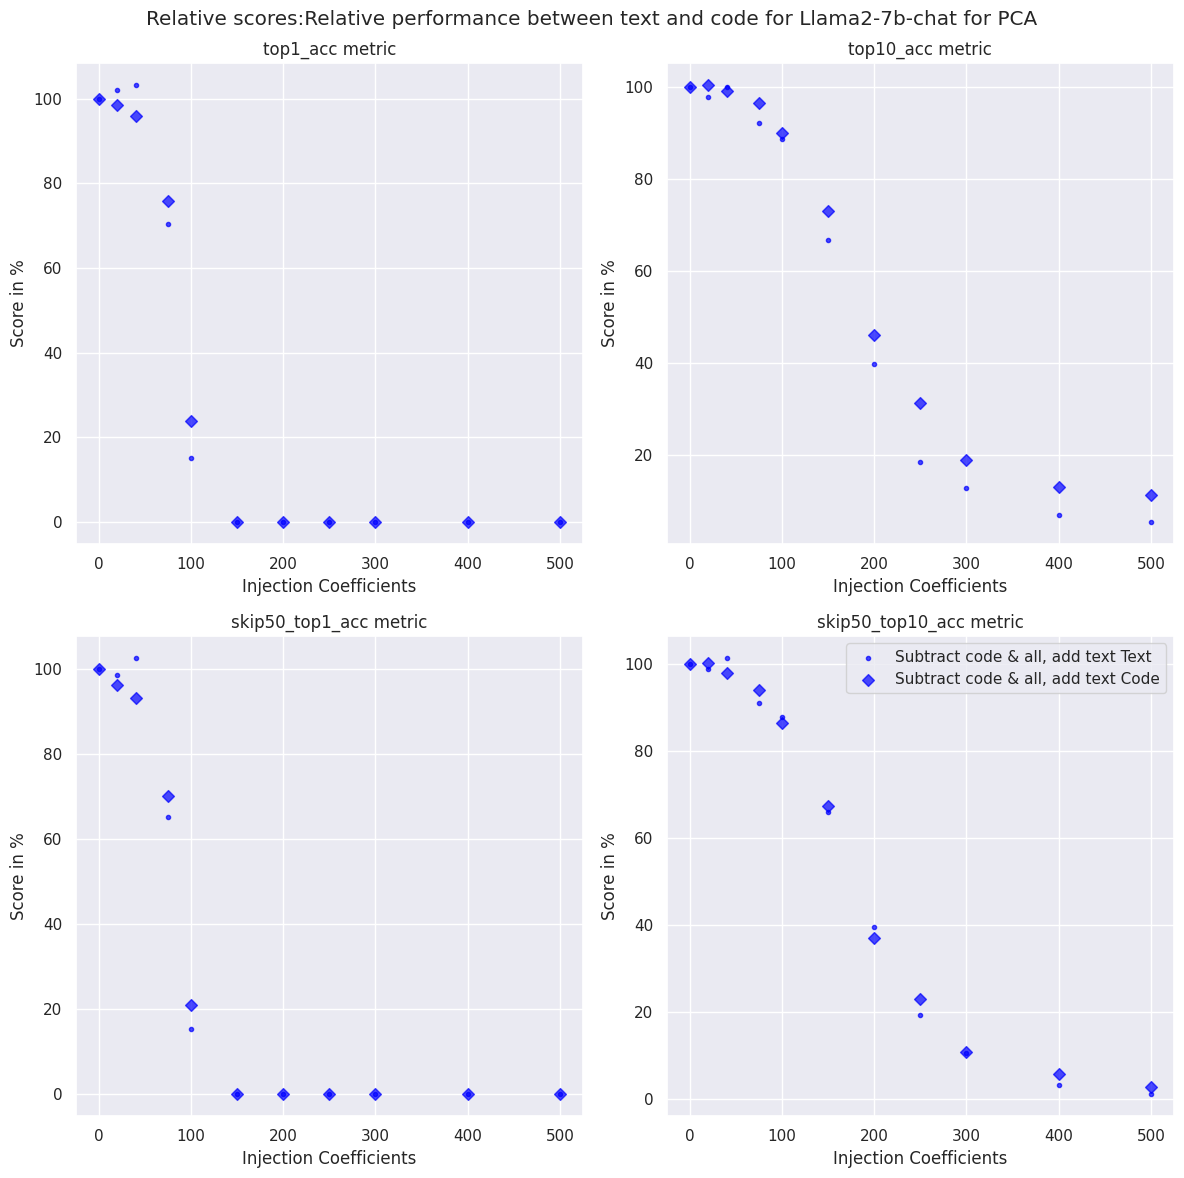

In [11]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))#, sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    # ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["rel"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["rel"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")

plt.legend()
plt.suptitle("Relative scores:" + title)
fig.tight_layout()
plt.show()

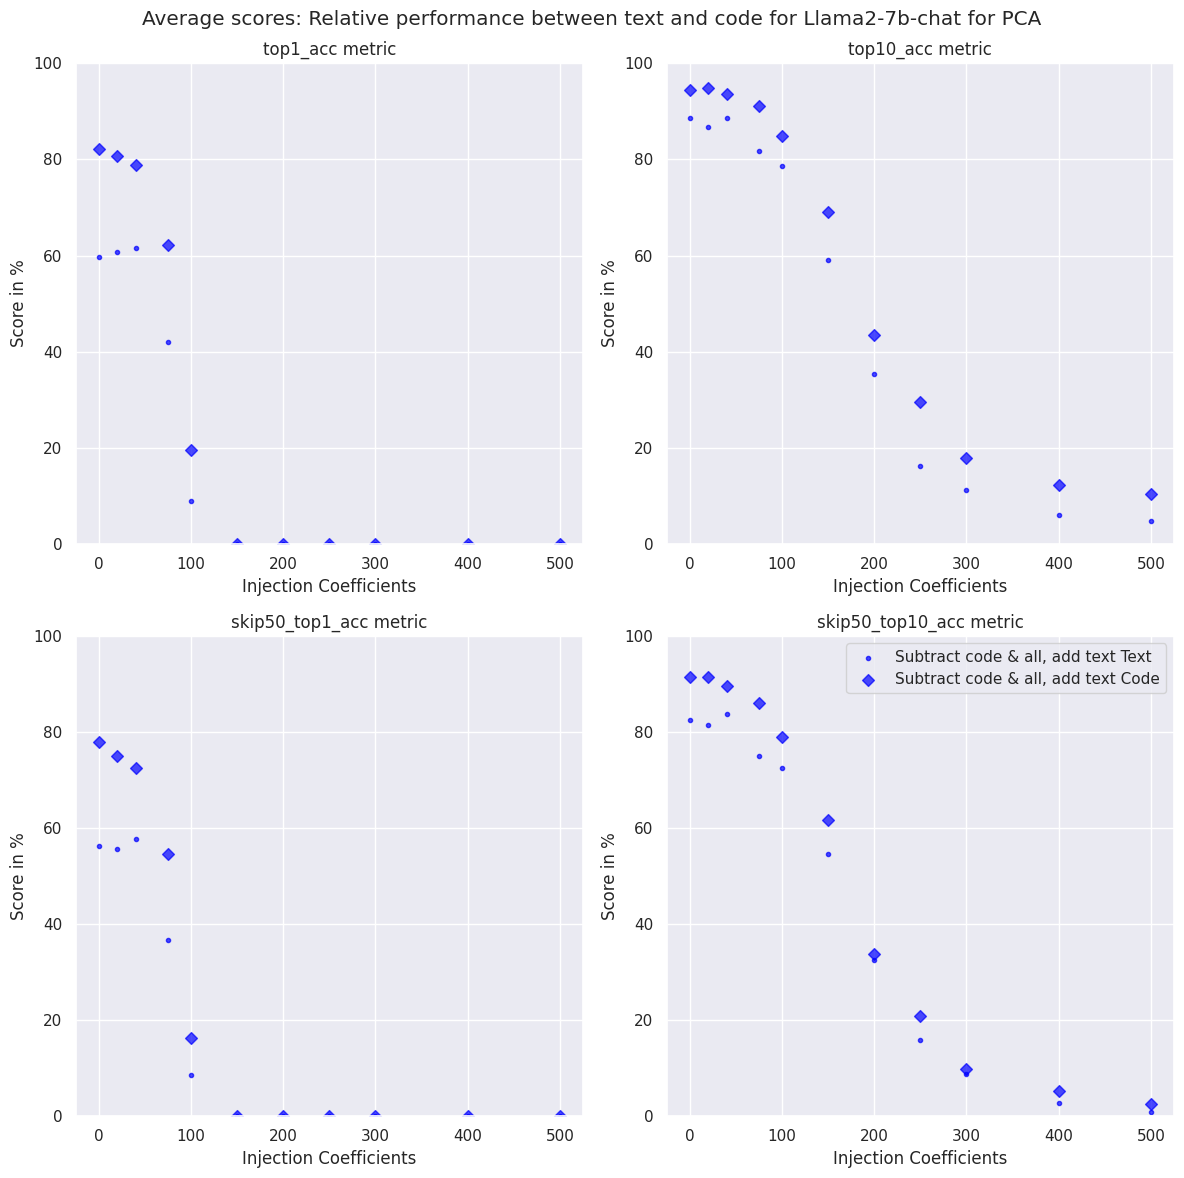

In [12]:
# create a seaborn style graph
sns.set_theme()
fig, axs = plt.subplots(2, 2, figsize=(12, 12))#, sharex=True, sharey=True)
scale = 100
ic_ints = results[0]["meta"]["injection_coefficients"]
colours = ["blue", "orange", "green", "red"]
for metric, ax in zip(metrics, axs.reshape(-1)):
    ax.set_ylim([0, 100])
    for score, label, colour in zip(scores, labels, colours):
        ax.scatter(ic_ints, score['only_text'][metric]["avg"], marker=".", alpha=0.7, c=colour, label=f"{label} Text")
        ax.scatter(ic_ints, score['only_code'][metric]["avg"], marker="D", alpha=0.7, c=colour, label=f"{label} Code")

    
    ax.set_title(f"{metric} metric")

    ax.set_xlabel("Injection Coefficients")
    ax.set_ylabel("Score in %")
    
plt.legend()
plt.suptitle("Average scores: " + title)
fig.tight_layout()
plt.show()